In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import sklearn.linear_model
import sklearn.neighbors

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')

import warnings
warnings.filterwarnings("ignore")

import sklearn
from collections import Counter 
import imblearn
import mrmr

In [ ]:
mrmr.mrmr_classif()

In [57]:
data_full = pd.read_csv('full_data_short.csv')

In [58]:
data_full = data_full.drop(columns='assay_ID')

In [59]:
def handle_scale_and_nan(frame,nandecision='drop',scale='MinMax'):
    features = list(frame.select_dtypes(include='float64'))
    cat = list(frame.select_dtypes(include='object'))

    if scale == 'MinMax':
        scaler = sklearn.preprocessing.MinMaxScaler().fit(frame[features])
    elif scale == 'Standard':
        scaler = sklearn.preprocessing.StandardScaler().fit(frame[features])
        
    df_cont = pd.DataFrame(data=scaler.transform(frame[features]), columns=features)
    df_cat = pd.DataFrame(data=frame[cat], columns=cat)
    
    frame = pd.concat([df_cat,df_cont],axis=1)
    
    if nandecision == 'mean':
            for feature in features:
                frame[feature].fillna((frame[feature].mean()), inplace=True)
    elif nandecision == 'drop':
            frame = frame.dropna(axis=1)
        
    return frame

In [60]:
data_full = handle_scale_and_nan(data_full,nandecision='drop',scale='MinMax')

In [91]:
def split_cats_by_tolerance(frame,tolerance,silent=False,randomstate=None,split=0.15,step=1,categories=['Healthy','AD_MCI','PD','PD_MCI_LBD']):
    tolerable_list =[]
    if randomstate == None:
        randomstate=np.random.randint(0,2**31)
    elif type(randomstate) == int:
        pass
    while sum(tolerable_list) != 4:
        df_dev, df_test = sklearn.model_selection.train_test_split(frame,test_size=split,random_state=randomstate)
        
        dev_dict = dict(df_dev['group'].value_counts())
        test_dict = dict(df_test['group'].value_counts())
        
        tolerable_list = []
        stats_dict ={}
        for i in range(0,len(categories)):
            try:
                percents = [(dev_dict[categories[i]]/len(df_dev)),(test_dict[categories[i]]/len(df_test))]
            except:
                break
            standdev = np.std(percents)
            if standdev <= tolerance:
                tolerable_list.append(1)
                stats_dict[str(categories[i])] = [[*percents],standdev]
            else:
                tolerable_list.append(0)
                
        randomstate += step

    if sum(tolerable_list) == 4:
        if silent == False:
            print(dev_dict)
            print(test_dict)
            print('Randstate:',randomstate-1)
            for i in range(0,len(categories)):            
                print('\nPercent',categories[i],'in dev, test:',stats_dict[categories[i]][0],
                      '\nStandard deviation of these values:',stats_dict[categories[i]][1],'\n')
        elif silent == True:
            pass
            
    return df_dev, df_test, randomstate-1


In [83]:
data_dev, data_test, randstate = split_cats_by_tolerance(data_full,0.01,randomstate=98281)

{'Healthy': 132, 'AD_MCI': 43, 'PD_MCI_LBD': 32, 'PD': 31}
{'Healthy': 24, 'AD_MCI': 8, 'PD_MCI_LBD': 5, 'PD': 5}
Randstate: 98281

Percent Healthy in dev, test: [0.5546218487394958, 0.5714285714285714] 
Standard deviation of these values: 0.008403361344537785 


Percent AD_MCI in dev, test: [0.18067226890756302, 0.19047619047619047] 
Standard deviation of these values: 0.004901960784313722 


Percent PD in dev, test: [0.13025210084033614, 0.11904761904761904] 
Standard deviation of these values: 0.005602240896358551 


Percent PD_MCI_LBD in dev, test: [0.13445378151260504, 0.11904761904761904] 
Standard deviation of these values: 0.007703081232492998 



In [65]:
def over_under(df_train,df_val,cat_in_excess='Healthy',target='group',randomstate=np.random.randint(0,4294967295)):
    """
    Takes dataframe(s) with only the target value and float64 features
    This function is to balance the samples in an imbalanced training dataset that has one category in excess, with additional categories more near each other
    The categories below the category in excess will be oversampled to equality, then the category in excess will be undersampled to equality
    ---Parameters---
    df_train: the training dataframe
    df_val: the validation dataframe
    cat_in_excess: the category which is present in excess, far above the other categories
    target: target column in the dataframe
    randomstate: if chosen, this will the random state for the sampling. Default: None, numpy random integer method between 0 and 4294967295, the range of the sampling module used
    randomstate_sampler: the number of loops to run to compare random states starting from 
    """

        
    # Drop the excessive category and oversample minority to the intermediate category
    df_train_no_excess = df_train[df_train.group != cat_in_excess]
    over_sampler = imblearn.over_sampling.RandomOverSampler(random_state=randomstate)
    X_train = df_train_no_excess.drop(columns=target)
    y_train = df_train_no_excess[target]
    X_train_over, y_train_over = over_sampler.fit_resample(X_train,y_train)
    df_train_over = pd.concat([y_train_over,X_train_over],axis=1)

    # Re-introduce the excessive category and undersample the majority to the minority
    df_train_excess = pd.concat([df_train_over,df_train[df_train[target] == cat_in_excess]])
    under_sampler = imblearn.under_sampling.RandomUnderSampler(random_state=randomstate)
    X_train = df_train_excess.drop(columns=target)
    y_train = df_train_excess[target]
    X_train_under, y_train_under = under_sampler.fit_resample(X_train,y_train)
    df_train_eq = pd.concat([y_train_under,X_train_under],axis=1)
        
    return df_train_eq, randomstate

        


In [90]:
def mrmr_feature_selection(X_train, y_train,X_val,y_val,K,model):
    feature_performance = []
    for k in K:
        reduced_features = mrmr.mrmr_classif(X_train,y_train,K=k)
        X_train_reduced = X_train[reduced_features]
        X_val_reduced = X_val[reduced_features]
        model.fit(X_train_reduced,y_train)
        feature_performance.append([k,sklearn.metrics.balanced_accuracy_score(y_val,model.predict(X_val_reduced)),reduced_features])
    #feature_performance.append([len(X_train.columns),model.score(X_val_reduced|,y_val),X_train.columns])
    return feature_performance

In [221]:
folded_performances = []
i=0
while i < 5:
    # Split dev data
    data_train, data_val, randstate = split_cats_by_tolerance(data_dev,0.01,silent=True)

    # Equalize the training data
    train_eq, randomstate = over_under(data_train,data_val)

    # Separate features from categories
    X_traineq = train_eq.drop(columns='group')
    y_traineq = train_eq['group']
    X_val = data_val.drop(columns='group')
    y_val = data_val['group']
    feature_performances = mrmr_feature_selection(X_traineq,y_traineq,X_val,y_val,range(1,100),sklearn.linear_model.RidgeClassifier())
    folded_performances.append(feature_performances)
    i += 1


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [00:02<00:00, 12.96it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 12.19it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 15.00it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 99/99 [00:07<00:00, 12.94it/s]


In [223]:
folded_performances = pd.DataFrame(data=folded_performances)
folded_performances

,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
0,"[1, 0.31666666666666665, [1433G]]","[2, 0.3416666666666667, [1433G, CNTP5]]","[3, 0.35416666666666663, [1433G, CNTP5, MA1C1]]","[4, 0.35416666666666663, [1433G, CNTP5, MA1C1,...","[5, 0.35416666666666663, [1433G, CNTP5, MA1C1,...","[6, 0.4916666666666666, [1433G, CNTP5, MA1C1, ...","[7, 0.4291666666666667, [1433G, CNTP5, MA1C1, ...","[8, 0.37916666666666665, [1433G, CNTP5, MA1C1,...","[9, 0.4416666666666666, [1433G, CNTP5, MA1C1, ...","[10, 0.4416666666666666, [1433G, CNTP5, MA1C1,...",...,"[90, 0.5708333333333334, [1433G, CNTP5, MA1C1,...","[91, 0.4666666666666666, [1433G, CNTP5, MA1C1,...","[92, 0.4916666666666666, [1433G, CNTP5, MA1C1,...","[93, 0.5041666666666667, [1433G, CNTP5, MA1C1,...","[94, 0.5041666666666667, [1433G, CNTP5, MA1C1,...","[95, 0.5041666666666667, [1433G, CNTP5, MA1C1,...","[96, 0.5041666666666667, [1433G, CNTP5, MA1C1,...","[97, 0.5041666666666667, [1433G, CNTP5, MA1C1,...","[98, 0.5041666666666667, [1433G, CNTP5, MA1C1,...","[99, 0.4916666666666666, [1433G, CNTP5, MA1C1,..."
1,"[1, 0.35833333333333334, [PGK1]]","[2, 0.25833333333333336, [PGK1, MMP2]]","[3, 0.25833333333333336, [PGK1, MMP2, CAH1]]","[4, 0.22916666666666666, [PGK1, MMP2, CAH1, TAU]]","[5, 0.2791666666666667, [PGK1, MMP2, CAH1, TAU...","[6, 0.29166666666666663, [PGK1, MMP2, CAH1, TA...","[7, 0.31666666666666665, [PGK1, MMP2, CAH1, TA...","[8, 0.31666666666666665, [PGK1, MMP2, CAH1, TA...","[9, 0.31666666666666665, [PGK1, MMP2, CAH1, TA...","[10, 0.26666666666666666, [PGK1, MMP2, CAH1, T...",...,"[90, 0.44999999999999996, [PGK1, MMP2, CAH1, T...","[91, 0.44999999999999996, [PGK1, MMP2, CAH1, T...","[92, 0.4375, [PGK1, MMP2, CAH1, TAU, GPX5, PAL...","[93, 0.4375, [PGK1, MMP2, CAH1, TAU, GPX5, PAL...","[94, 0.4125, [PGK1, MMP2, CAH1, TAU, GPX5, PAL...","[95, 0.4, [PGK1, MMP2, CAH1, TAU, GPX5, PAL4A,...","[96, 0.4125, [PGK1, MMP2, CAH1, TAU, GPX5, PAL...","[97, 0.4, [PGK1, MMP2, CAH1, TAU, GPX5, PAL4A,...","[98, 0.4125, [PGK1, MMP2, CAH1, TAU, GPX5, PAL...","[99, 0.4125, [PGK1, MMP2, CAH1, TAU, GPX5, PAL..."
2,"[1, 0.30833333333333335, [DPP6]]","[2, 0.2583333333333333, [DPP6, SCUB1]]","[3, 0.23333333333333334, [DPP6, SCUB1, VWF]]","[4, 0.2833333333333333, [DPP6, SCUB1, VWF, 143...","[5, 0.32499999999999996, [DPP6, SCUB1, VWF, 14...","[6, 0.4375, [DPP6, SCUB1, VWF, 1433G, TAU, CAD...","[7, 0.3833333333333333, [DPP6, SCUB1, VWF, 143...","[8, 0.47916666666666663, [DPP6, SCUB1, VWF, 14...","[9, 0.4916666666666666, [DPP6, SCUB1, VWF, 143...","[10, 0.44999999999999996, [DPP6, SCUB1, VWF, 1...",...,"[90, 0.5458333333333334, [DPP6, SCUB1, VWF, 14...","[91, 0.5458333333333334, [DPP6, SCUB1, VWF, 14...","[92, 0.6125, [DPP6, SCUB1, VWF, 1433G, TAU, CA...","[93, 0.6125, [DPP6, SCUB1, VWF, 1433G, TAU, CA...","[94, 0.625, [DPP6, SCUB1, VWF, 1433G, TAU, CAD...","[95, 0.6125, [DPP6, SCUB1, VWF, 1433G, TAU, CA...","[96, 0.625, [DPP6, SCUB1, VWF, 1433G, TAU, CAD...","[97, 0.6125, [DPP6, SCUB1, VWF, 1433G, TAU, CA...","[98, 0.6125, [DPP6, SCUB1, VWF, 1433G, TAU, CA...","[99, 0.6000000000000001, [DPP6, SCUB1, VWF, 14..."
3,"[1, 0.3416666666666667, [1433G]]","[2, 0.3458333333333333, [1433G, AGRB2]]","[3, 0.29583333333333334, [1433G, AGRB2, LY96]]","[4, 0.3458333333333333, [1433G, AGRB2, LY96, C...","[5, 0.2625, [1433G, AGRB2, LY96, CEMIP, CHIT1]]","[6, 0.3625, [1433G, AGRB2, LY96, CEMIP, CHIT1,...","[7, 0.3541666666666667, [1433G, AGRB2, LY96, C...","[8, 0.36666666666666664, [1433G, AGRB2, LY96, ...","[9, 0.47916666666666663, [1433G, AGRB2, LY96, ...","[10, 0.47916666666666663, [1433G, AGRB2, LY96,...",...,"[90, 0.5791666666666667, [1433G, AGRB2, LY96, ...","[91, 0.5791666666666667, [1433G, AGRB2, LY96, ...","[92, 0.6083333333333334, [1433G, AGRB2, LY96, ...","[93, 0.6083333333333334, [1433G, AGRB2, LY96, ...","[94, 0.6083333333333334, [1433G, AGRB2, LY96, ...","[95, 0.5666666666666667, [1433G, AGRB2, LY96, ...","[96, 0.5666666666666667, [1433G, AGRB2, LY96, ...","[97, 0.5666666666666667, [1433G, AGRB2, LY

In [278]:
folded_performances

,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
0,"[1, 0.31666666666666665, [1433G]]","[2, 0.3416666666666667, [1433G, CNTP5]]","[3, 0.35416666666666663, [1433G, CNTP5, MA1C1]]","[4, 0.35416666666666663, [1433G, CNTP5, MA1C1,...","[5, 0.35416666666666663, [1433G, CNTP5, MA1C1,...","[6, 0.4916666666666666, [1433G, CNTP5, MA1C1, ...","[7, 0.4291666666666667, [1433G, CNTP5, MA1C1, ...","[8, 0.37916666666666665, [1433G, CNTP5, MA1C1,...","[9, 0.4416666666666666, [1433G, CNTP5, MA1C1, ...","[10, 0.4416666666666666, [1433G, CNTP5, MA1C1,...",...,"[90, 0.5708333333333334, [1433G, CNTP5, MA1C1,...","[91, 0.4666666666666666, [1433G, CNTP5, MA1C1,...","[92, 0.4916666666666666, [1433G, CNTP5, MA1C1,...","[93, 0.5041666666666667, [1433G, CNTP5, MA1C1,...","[94, 0.5041666666666667, [1433G, CNTP5, MA1C1,...","[95, 0.5041666666666667, [1433G, CNTP5, MA1C1,...","[96, 0.5041666666666667, [1433G, CNTP5, MA1C1,...","[97, 0.5041666666666667, [1433G, CNTP5, MA1C1,...","[98, 0.5041666666666667, [1433G, CNTP5, MA1C1,...","[99, 0.4916666666666666, [1433G, CNTP5, MA1C1,..."
1,"[1, 0.35833333333333334, [PGK1]]","[2, 0.25833333333333336, [PGK1, MMP2]]","[3, 0.25833333333333336, [PGK1, MMP2, CAH1]]","[4, 0.22916666666666666, [PGK1, MMP2, CAH1, TAU]]","[5, 0.2791666666666667, [PGK1, MMP2, CAH1, TAU...","[6, 0.29166666666666663, [PGK1, MMP2, CAH1, TA...","[7, 0.31666666666666665, [PGK1, MMP2, CAH1, TA...","[8, 0.31666666666666665, [PGK1, MMP2, CAH1, TA...","[9, 0.31666666666666665, [PGK1, MMP2, CAH1, TA...","[10, 0.26666666666666666, [PGK1, MMP2, CAH1, T...",...,"[90, 0.44999999999999996, [PGK1, MMP2, CAH1, T...","[91, 0.44999999999999996, [PGK1, MMP2, CAH1, T...","[92, 0.4375, [PGK1, MMP2, CAH1, TAU, GPX5, PAL...","[93, 0.4375, [PGK1, MMP2, CAH1, TAU, GPX5, PAL...","[94, 0.4125, [PGK1, MMP2, CAH1, TAU, GPX5, PAL...","[95, 0.4, [PGK1, MMP2, CAH1, TAU, GPX5, PAL4A,...","[96, 0.4125, [PGK1, MMP2, CAH1, TAU, GPX5, PAL...","[97, 0.4, [PGK1, MMP2, CAH1, TAU, GPX5, PAL4A,...","[98, 0.4125, [PGK1, MMP2, CAH1, TAU, GPX5, PAL...","[99, 0.4125, [PGK1, MMP2, CAH1, TAU, GPX5, PAL..."
2,"[1, 0.30833333333333335, [DPP6]]","[2, 0.2583333333333333, [DPP6, SCUB1]]","[3, 0.23333333333333334, [DPP6, SCUB1, VWF]]","[4, 0.2833333333333333, [DPP6, SCUB1, VWF, 143...","[5, 0.32499999999999996, [DPP6, SCUB1, VWF, 14...","[6, 0.4375, [DPP6, SCUB1, VWF, 1433G, TAU, CAD...","[7, 0.3833333333333333, [DPP6, SCUB1, VWF, 143...","[8, 0.47916666666666663, [DPP6, SCUB1, VWF, 14...","[9, 0.4916666666666666, [DPP6, SCUB1, VWF, 143...","[10, 0.44999999999999996, [DPP6, SCUB1, VWF, 1...",...,"[90, 0.5458333333333334, [DPP6, SCUB1, VWF, 14...","[91, 0.5458333333333334, [DPP6, SCUB1, VWF, 14...","[92, 0.6125, [DPP6, SCUB1, VWF, 1433G, TAU, CA...","[93, 0.6125, [DPP6, SCUB1, VWF, 1433G, TAU, CA...","[94, 0.625, [DPP6, SCUB1, VWF, 1433G, TAU, CAD...","[95, 0.6125, [DPP6, SCUB1, VWF, 1433G, TAU, CA...","[96, 0.625, [DPP6, SCUB1, VWF, 1433G, TAU, CAD...","[97, 0.6125, [DPP6, SCUB1, VWF, 1433G, TAU, CA...","[98, 0.6125, [DPP6, SCUB1, VWF, 1433G, TAU, CA...","[99, 0.6000000000000001, [DPP6, SCUB1, VWF, 14..."
3,"[1, 0.3416666666666667, [1433G]]","[2, 0.3458333333333333, [1433G, AGRB2]]","[3, 0.29583333333333334, [1433G, AGRB2, LY96]]","[4, 0.3458333333333333, [1433G, AGRB2, LY96, C...","[5, 0.2625, [1433G, AGRB2, LY96, CEMIP, CHIT1]]","[6, 0.3625, [1433G, AGRB2, LY96, CEMIP, CHIT1,...","[7, 0.3541666666666667, [1433G, AGRB2, LY96, C...","[8, 0.36666666666666664, [1433G, AGRB2, LY96, ...","[9, 0.47916666666666663, [1433G, AGRB2, LY96, ...","[10, 0.47916666666666663, [1433G, AGRB2, LY96,...",...,"[90, 0.5791666666666667, [1433G, AGRB2, LY96, ...","[91, 0.5791666666666667, [1433G, AGRB2, LY96, ...","[92, 0.6083333333333334, [1433G, AGRB2, LY96, ...","[93, 0.6083333333333334, [1433G, AGRB2, LY96, ...","[94, 0.6083333333333334, [1433G, AGRB2, LY96, ...","[95, 0.5666666666666667, [1433G, AGRB2, LY96, ...","[96, 0.5666666666666667, [1433G, AGRB2, LY96, ...","[97, 0.5666666666666667, [1433G, AGRB2, LY

In [286]:
performance_mean = []
nonmeanie = []
for j in range(0,len(folded_performances.columns)):
    listy = []
    for i in range(0,len(folded_performances)):
        folded_list = folded_performances[j].iloc[i]
        a = folded_list[0]
        b = folded_list[1]
        c = folded_list[2]
        listy.append([a,b,c])

    bs = []
    for i in range(0,len(listy)):
        bs.append(listy[i][1])
    meanie = np.mean(bs)
    nonmeanie.append([a,bs])

    featies = []
    for i in range(0,len(listy)):
        featies.append(listy[i][2])
    featies = list(np.unique(featies))

    performance_mean.append([a,meanie,featies])

In [291]:
df_nonmeanie = pd.DataFrame(data=nonmeanie, columns=['num_features','scores'])

In [293]:
df_nonmeanie.to_csv('nonmeanie.csv')

In [281]:
performance_mean

[[1, 0.32, ['1433G', 'DPP6', 'PGK1', 'TAU']],
 [2,
  0.29,
  ['1433G', 'AGRB2', 'AMYP', 'CNTP5', 'DPP6', 'MMP2', 'PGK1', 'SCUB1', 'TAU']],
 [3,
  0.29000000000000004,
  ['1433G',
   'AGRB2',
   'AMYP',
   'CAH1',
   'CNTP5',
   'DPP6',
   'LY96',
   'MA1C1',
   'MMP2',
   'PGK1',
   'PPIB',
   'SCUB1',
   'TAU',
   'VWF']],
 [4,
  0.2816666666666666,
  ['1433G',
   'AGRB2',
   'AMYP',
   'C1QB',
   'CAH1',
   'CEMIP',
   'CNTP5',
   'DPP6',
   'LY96',
   'MA1C1',
   'MMP2',
   'PGK1',
   'PILRA',
   'PPIB',
   'SCUB1',
   'TAU',
   'VWF']],
 [5,
  0.30333333333333334,
  ['1433G',
   'AGRB2',
   'AMYP',
   'C1QB',
   'CAH1',
   'CALC',
   'CEMIP',
   'CHIT1',
   'CNTP5',
   'DPP6',
   'GPX5',
   'HV103',
   'LY96',
   'MA1C1',
   'MMP2',
   'PGK1',
   'PILRA',
   'PPIB',
   'SCUB1',
   'TAU',
   'VWF']],
 [6,
  0.37333333333333335,
  ['1433G',
   'AGRB2',
   'AK1C1',
   'AMYP',
   'C1QB',
   'CADH5',
   'CAH1',
   'CALC',
   'CEMIP',
   'CHIT1',
   'CNTP5',
   'DPP6',
   'GPX5',
   'HV1

In [238]:
df_performance_mean = pd.DataFrame(data=performance_mean, columns=['num_features','five_fold_avg','feature_names'])

In [239]:
df_performance_mean

,num_features,five_fold_avg,feature_names
0,1,0.320000,"[1433G, DPP6, PGK1, TAU]"
1,2,0.290000,"[1433G, AGRB2, AMYP, CNTP5, DPP6, MMP2, PGK1, ..."
2,3,0.290000,"[1433G, AGRB2, AMYP, CAH1, CNTP5, DPP6, LY96, ..."
3,4,0.281667,"[1433G, AGRB2, AMYP, C1QB, CAH1, CEMIP, CNTP5,..."
4,5,0.303333,"[1433G, AGRB2, AMYP, C1QB, CAH1, CALC, CEMIP, ..."
...,...,...,...
94,95,0.514167,"[1433B, 1433F, 1433G, 1433T, 1433Z, A0A075B7D0..."
95,96,0.519167,"[1433B, 1433F, 1433G, 1433T, 1433Z, A0A075B7D0..."
96,97,0.516667,"[1433B, 1433F, 1433G, 1433T, 1433Z, A0A075B7D0..."
97,98,0.519167,"[1433B, 1433F, 1433G, 1433T, 1433Z, A0A075B7D0..."


In [241]:
df_performance_mean.to_csv('feature_performance_100.csv')

In [262]:
df_performance_mean

,num_features,five_fold_avg,feature_names
0,1,0.320000,"[1433G, DPP6, PGK1, TAU]"
1,2,0.290000,"[1433G, AGRB2, AMYP, CNTP5, DPP6, MMP2, PGK1, ..."
2,3,0.290000,"[1433G, AGRB2, AMYP, CAH1, CNTP5, DPP6, LY96, ..."
3,4,0.281667,"[1433G, AGRB2, AMYP, C1QB, CAH1, CEMIP, CNTP5,..."
4,5,0.303333,"[1433G, AGRB2, AMYP, C1QB, CAH1, CALC, CEMIP, ..."
...,...,...,...
94,95,0.514167,"[1433B, 1433F, 1433G, 1433T, 1433Z, A0A075B7D0..."
95,96,0.519167,"[1433B, 1433F, 1433G, 1433T, 1433Z, A0A075B7D0..."
96,97,0.516667,"[1433B, 1433F, 1433G, 1433T, 1433Z, A0A075B7D0..."
97,98,0.519167,"[1433B, 1433F, 1433G, 1433T, 1433Z, A0A075B7D0..."


In [226]:
number, score, names = zip(*performance_mean)

Text(0, 0.5, 'Balanced accuracy score')

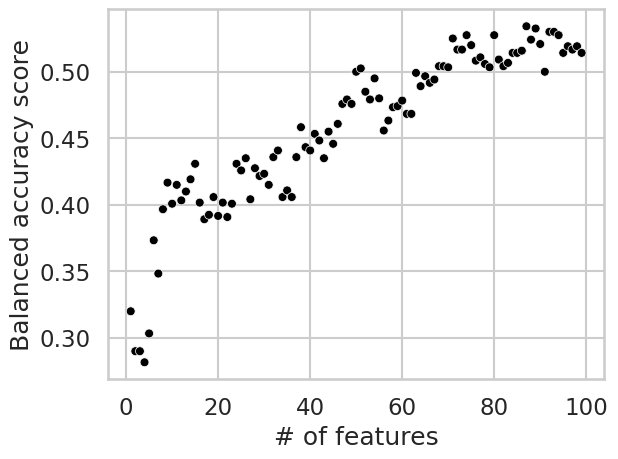

In [234]:
sns.scatterplot(x=number,y=score,color='black',size=1,legend=False)
plt.xlabel('# of features')
plt.ylabel('Balanced accuracy score')

In [ ]:
#folded_performances = pd.DataFrame(data=listy,columns=['num_feat','score','features'])

In [264]:
df_many_features = pd.read_csv('features.csv')

In [266]:
list_many_features = df_many_features.columns

In [277]:
list_many_features[2]

" 'PGK1'"

In [274]:
unique, counts = np.unique(np.array(list_many_features), return_counts=True)
np.asarray((unique, counts)).T

array([[" '1433B'", 1],
       [" '1433B'.1", 1],
       [" '1433B'.2", 1],
       ...,
       [" 1433G'.6", 1],
       [" 1433G'.7", 1],
       ["['1433G'", 1]], dtype=object)

In [ ]:
df_counted_features = pd.DataFrame(data=)

In [268]:
np.unique(list_many_features)

array([" '1433B'", " '1433B'.1", " '1433B'.2", ..., " 1433G'.6",
       " 1433G'.7", "['1433G'"], dtype=object)

In [158]:
folded_performances

,num_feat,score,features
0,1,0.416667,[TAU]
1,1,0.275000,[TAU]
2,1,0.312500,[1433Z]
3,1,0.266667,[TAU]
4,1,0.379167,[1433Z]


In [100]:
formatted_performances = pd.DataFrame()

In [222]:
range(0,100,1)

range(0, 100)